<a href="https://colab.research.google.com/github/mikislin/CNE25/blob/main/notebooks/CNE_Class2_Stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical simulation tool.
Features:
- Interactive widgets for Normal, Ex-Gaussian, Shifted Log-Normal
- Theoretical PDF plotted when available
- Random seed control
- Download generated sample as .npy or .csv


In [ ]:
#@title import libraries and install missing
# Install ipywidgets if necessary
try:
    from statsmodels.stats.power import TTestIndPower
    import ipywidgets as widgets
except ImportError:
    import sys
    print("Installing required libraries (statsmodels and ipywidgets)...")
    !{sys.executable} -m pip install --quiet statsmodels ipywidgets
    from statsmodels.stats.power import TTestIndPower
    import ipywidgets as widgets
    print("Installation complete.")


import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from ipywidgets import interactive, Dropdown, IntSlider, FloatSlider, HBox, VBox, Button, Output
from IPython.display import display, clear_output
from scipy import stats
import statsmodels.formula.api as smf

In [ ]:
# @title Distribution definitions
def normal_sample(size: int, loc: float, scale: float, seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    return np.random.normal(loc=loc, scale=scale, size=size)

def normal_pdf(x: np.ndarray, loc: float, scale: float):
    return stats.norm.pdf(x, loc=loc, scale=scale)

def exgaussian_sample(size: int, loc: float, scale: float, tau: float, seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    return np.random.normal(loc=loc, scale=scale, size=size) + np.random.exponential(scale=tau, size=size)

def shifted_lognormal_sample(size: int, mu: float, sigma: float, shift: float, seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    return np.exp(np.random.normal(loc=mu, scale=sigma, size=size)) + shift

def shifted_lognormal_pdf(x: np.ndarray, mu: float, sigma: float, shift: float):
    out = np.zeros_like(x, dtype=float)
    mask = x > shift
    xm = x[mask] - shift
    out[mask] = stats.lognorm.pdf(xm, s=sigma, scale=np.exp(mu))
    return out

def bernoulli_sample(size: int, p: float, seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    return stats.bernoulli.rvs(p, size=size)

def bernoulli_pdf(x: np.ndarray, p: float):
    return stats.bernoulli.pmf(x, p)

def betanbinom_sample(size: int, n: int, alpha: float, beta: float, seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    p = stats.beta.rvs(alpha, beta)
    return stats.nbinom.rvs(n, p, size=size)

def f_sample(size: int, dfn: int, dfd: int, seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    return stats.f.rvs(dfn, dfd, size=size)

def f_pdf(x: np.ndarray, dfn: int, dfd: int):
    return stats.f.pdf(x, dfn, dfd)

def t_sample(size: int, df: int, seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    return stats.t.rvs(df, size=size)

def t_pdf(x: np.ndarray, df: int):
    return stats.t.pdf(x, df)

def z_sample(size: int, seed: int = None):
    if seed is not None:
        np.random.seed(seed)
    return stats.norm.rvs(size=size)

def z_pdf(x: np.ndarray):
    return stats.norm.pdf(x)

def poisson_sample(size: int, lam: float, seed: int=None):
    if seed is not None:
        np.random.seed(seed)
    return stats.poisson.rvs(mu=lam, size=size)

def poisson_pdf(x: np.ndarray, lam: float):
    return stats.poisson.pmf(x, mu=lam)

def poisson_binomial_sample(size: int, probs: list, seed: int=None):
    if seed is not None:
        np.random.seed(seed)
    trials = [stats.bernoulli.rvs(p, size=size) for p in probs]
    return np.sum(trials, axis=0)


In [ ]:
# @title equations and linear models references
# equations ------------------------------------------------------------------
_equations = {
    'Normal': r"$f(x; \mu, \sigma) = \\frac{1}{\\sigma \\sqrt{2 \\pi}} e^{-\\frac{(x-\\mu)^2}{2\\sigma^2}}$",
    'Ex-Gaussian': r"PDF omitted (convolution of Gaussian and Exponential)",
    'Shifted Log-Normal': r"$f(x; \\mu, \\sigma, s) = \\frac{1}{(x-s)\\sigma \\sqrt{2 \\pi}} e^{-\\frac{(\\ln(x-s)-\\mu)^2}{2\\sigma^2}}, \\ x>s$",
    'Bernoulli': r"$P(X=x) = p^x (1-p)^{1-x}, \\ x \\in {0,1}$",
    'Beta-Negative-Binomial': "Beta prior on probability, mixture distribution (no simple closed-form PDF).",
    'F': r"$f(x; d_1,d_2) = \\frac{1}{B(d_1/2, d_2/2)} (\\frac{d_1}{d_2})^{d_1/2} \\frac{x^{d_1/2 - 1}}{(1 + \\frac{d_1}{d_2}x)^{(d_1+d_2)/2}}$",
    't': r"$f(x; \\nu) = \\frac{\\Gamma((\\nu+1)/2)}{\\sqrt{\\nu \\pi} \\Gamma(\\nu/2)} (1+\\frac{x^2}{\\nu})^{-(\\nu+1)/2}$",
    'Z (Standard Normal)': r"$f(x) = \\frac{1}{\\sqrt{2\\pi}} e^{-x^2/2}$"
}

# linear model equivalents in statsmodels formula style
_linear_models = {
    'Normal': "smf.ols(formula='Y ~ 1', data=df).fit()",
    'Ex-Gaussian': "Not directly in smf — mixture model; can be fit via MLE",
    'Shifted Log-Normal': "smf.ols(formula='np.log(Y - shift) ~ X', data=df).fit()",
    'Bernoulli': "smf.logit(formula='Y ~ X', data=df).fit()",
    'Beta-Negative-Binomial': "GLM: smf.glm(formula='Y ~ X', family=sm.families.NegativeBinomial(), data=df).fit() with beta prior",
    'F': "smf.ols(formula='Y ~ C(group)', data=df).fit(); sm.stats.anova_lm(model)",
    't': "smf.ols(formula='Y ~ group', data=df).fit(); sm.stats.ttest_ind(...)",
    'Z (Standard Normal)': "smf.ols(formula='Y ~ 1', data=df).fit(); z-test under known σ",
    'Poisson': "smf.poisson(formula='Y ~ X', data=df).fit()",
    'Poisson-Binomial': "Generalized model of independent Bernoulli trials; simulate via convolution, not in smf"
}



In [ ]:
#@title Widgets
# Widget factory helpers -----------------------------------------------------
def float_slider(value, min_, max_, step, description):
    return FloatSlider(value=value, min=min_, max=max_, step=step, description=description, continuous_update=False)

def int_slider(value, min_, max_, step, description):
    return IntSlider(value=value, min=min_, max=max_, step=step, description=description, continuous_update=False)

# Build distributions dict with widgets
_distributions = {
    'Normal': {
        'sample_fn': normal_sample,
        'param_widgets': {
            'loc': float_slider(0.0, -5.0, 5.0, 0.1, 'μ (mean)'),
            'scale': float_slider(1.0, 0.1, 5.0, 0.1, 'σ (std)')
        },
        'pdf_fn': normal_pdf
    },
    'Ex-Gaussian': {
        'sample_fn': exgaussian_sample,
        'param_widgets': {
            'loc': float_slider(500.0, 100.0, 1000.0, 10.0, 'μ (mu)'),
            'scale': float_slider(50.0, 10.0, 200.0, 5.0, 'σ (sigma)'),
            'tau': float_slider(150.0, 50.0, 500.0, 10.0, 'τ (tau)')
        },
        'pdf_fn': None
    },
    'Shifted Log-Normal': {
        'sample_fn': shifted_lognormal_sample,
        'param_widgets': {
            'mu': float_slider(6.0, 4.0, 8.0, 0.1, 'μ (log-mean)'),
            'sigma': float_slider(0.4, 0.1, 2.0, 0.1, 'σ (log-std)'),
            'shift': float_slider(200.0, 0.0, 500.0, 10.0, 'shift')
        },
        'pdf_fn': shifted_lognormal_pdf
    },
    'Bernoulli': {
        'sample_fn': bernoulli_sample,
        'param_widgets': {
            'p': float_slider(0.5, 0.0, 1.0, 0.01, 'p')
        },
        'pdf_fn': bernoulli_pdf
    },
    'Beta-Negative-Binomial': {
        'sample_fn': betanbinom_sample,
        'param_widgets': {
            'n': int_slider(10, 1, 100, 1, 'n'),
            'alpha': float_slider(2.0, 0.1, 10.0, 0.1, 'alpha'),
            'beta': float_slider(2.0, 0.1, 10.0, 0.1, 'beta')
        },
        'pdf_fn': None
    },
    'F': {
        'sample_fn': f_sample,
        'param_widgets': {
            'dfn': int_slider(5, 1, 50, 1, 'dfn'),
            'dfd': int_slider(10, 1, 50, 1, 'dfd')
        },
        'pdf_fn': f_pdf
    },
    't': {
        'sample_fn': t_sample,
        'param_widgets': {
            'df': int_slider(10, 1, 100, 1, 'df')
        },
        'pdf_fn': t_pdf
    },
    'Z (Standard Normal)': {
        'sample_fn': z_sample,
        'param_widgets': {},
        'pdf_fn': z_pdf
    },
    'Poisson': {
        'sample_fn': poisson_sample,
        'param_widgets': {'lam': float_slider(5.0, 0.1, 20.0, 0.1, 'λ')},
        'pdf_fn': poisson_pdf
    },
    'Poisson-Binomial': {
        'sample_fn': poisson_binomial_sample,
        'param_widgets': {'p': float_slider(0.5, 0.0, 1.0, 0.01, 'p (equal)'),'k': int_slider(5, 1, 20, 1, 'n trials')},
        'pdf_fn': None
    }
}

# -- UI widgets ---------------------------------------------------------------
dist_dropdown = Dropdown(options=list(_distributions.keys()), description='Distribution:')
sample_size_slider = IntSlider(value=1000, min=50, max=20000, step=50, description='Sample Size:')
seed_slider = IntSlider(value=0, min=0, max=2**31-1, step=1, description='Seed (0=none):')

plot_output = Output()
data_output = Output()
controls_box = Output()

generate_button = Button(description='Generate Data & Show Array', button_style='primary')
download_npy_btn = Button(description='Download .npy')
download_csv_btn = Button(description='Download .csv')
export_dict_btn = Button(description='Export to Workspace Dict')

_last_sample = {'data': None, 'params': None, 'dist': None}

In [ ]:
#@title Core

def _get_param_values(dist_name: str):
    widgets = _distributions[dist_name]['param_widgets']
    return {k: w.value for k, w in widgets.items()}

def _get_sample(dist_name: str, sample_size: int, seed: int, params: dict):
    """
    Helper function to generate a sample, handling special cases like
    the Poisson-Binomial distribution where widget parameters need to be
    mapped to the sampling function's arguments.
    """
    sample_fn = _distributions[dist_name]['sample_fn']

    if dist_name == 'Poisson-Binomial':
        # The widgets provide 'p' and 'k'. The function needs 'probs'.
        # We create the 'probs' list from 'p' and 'k'.
        p = params.get('p', 0.5)
        k = params.get('k', 5)
        probs = [p] * k
        # Call the function with the correct argument name 'probs'.
        return sample_fn(size=sample_size, probs=probs, seed=seed)
    else:
        # For all other distributions, pass parameters as they are.
        return sample_fn(size=sample_size, seed=seed, **params)

def _on_generate_clicked(_):
    with data_output:
        clear_output(wait=True)
        dist_name = dist_dropdown.value
        sample_size = sample_size_slider.value
        seed = seed_slider.value
        params = _get_param_values(dist_name)

        # Use the new helper function to get the sample
        sample = _get_sample(
            dist_name=dist_name,
            sample_size=sample_size,
            seed=(None if seed == 0 else seed),
            params=params
        )

        _last_sample['data'] = sample
        _last_sample['params'] = params
        _last_sample['dist'] = dist_name

        print(f'Generated sample (first 20 of {sample_size}):')
        np.set_printoptions(precision=6, suppress=True)
        print(sample[:20])

        # Summary statistics
        print("\nSummary statistics:")
        print(f"Mean={np.mean(sample):.4f}, "
              f"Variance={np.var(sample):.4f}, "
              f"Skew={stats.skew(sample):.4f}, "
              f"Kurtosis={stats.kurtosis(sample):.4f}")

        # Equation and LM equivalence
        eqn = _equations.get(dist_name, "")
        lm = _linear_models.get(dist_name, "")
        display(Markdown(f"**Equation:** {eqn}"))
        display(Markdown(f"**Equivalent Linear Model:** {lm}"))


def _download_array_as_npy(_):
    if _last_sample['data'] is None:
        with data_output:
            print('No data generated yet.')
        return
    filename = 'sample.npy'
    np.save(filename, _last_sample['data'])
    try:
        from google.colab import files
        files.download(filename)
    except Exception:
        with data_output:
            print(f'Saved to {filename} in the Colab filesystem.')


def _download_array_as_csv(_):
    if _last_sample['data'] is None:
        with data_output:
            print('No data generated yet.')
        return
    filename = 'sample.csv'
    np.savetxt(filename, _last_sample['data'], delimiter=',')
    try:
        from google.colab import files
        files.download(filename)
    except Exception:
        with data_output:
            print(f'Saved to {filename} in the Colab filesystem.')


def _export_dict(_):
    if _last_sample['data'] is None:
        with data_output:
            print('No data generated yet.')
        return
    export_obj = {
        'distribution': _last_sample['dist'],
        'parameters': _last_sample['params'],
        'sample': _last_sample['data']
    }
    globals()['last_export'] = export_obj
    with data_output:
        print('Exported sample dictionary available as global variable `last_export`.')

stats_output = Output()

def update_plot(dist_name: str, sample_size: int, seed: int, **kwargs):
    with plot_output:
        clear_output(wait=True)

        # Use the new helper function to get the sample
        sample = _get_sample(
            dist_name=dist_name,
            sample_size=sample_size,
            seed=(None if seed == 0 else seed),
            params=kwargs
        )

        # apply scientific style
        plt.style.use('seaborn-v0_8-paper')
        fig, axs = plt.subplots(2, 1, figsize=(6, 6), dpi=72,
                                gridspec_kw={'height_ratios': [3, 1]})

        # histogram
        ax = axs[0]
        ax.hist(sample, bins=50, density=True,
                alpha=0.5, color="#4C72B0", edgecolor="black",
                label='Histogram')

        # theoretical PDF
        pdf_fn = _distributions[dist_name]['pdf_fn']
        if pdf_fn is not None:
            xmin, xmax = np.nanmin(sample), np.nanmax(sample)
            padding = (xmax - xmin) * 0.1 if xmax > xmin else 1.0
            x = np.linspace(xmin - padding, xmax + padding, 800)
            try:
                p = pdf_fn(x, **kwargs) if dist_name != 'Z (Standard Normal)' else pdf_fn(x)
                ax.plot(x, p, color='black', linewidth=2.0, label='Theoretical PDF')
            except Exception as e:
                print('Could not compute theoretical PDF:', e)

        ax.set_title(f'{dist_name} (n={sample_size})', fontsize=14, weight='bold')
        ax.set_xlabel('Value', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.tick_params(axis='both', labelsize=10)
        ax.grid(True, linestyle=':', linewidth=0.7)
        ax.legend(fontsize=10, frameon=False)

        # horizontal boxplot
        ax_box = axs[1]
        boxprops = dict(facecolor="#DDDDDD", color="black", linewidth=1.2)
        medianprops = dict(color="blue", linewidth=2)
        ax_box.boxplot(sample, vert=False, patch_artist=True,
                       boxprops=boxprops, medianprops=medianprops)

        # statistics
        mean, median = np.mean(sample), np.median(sample)
        q1, q3 = np.percentile(sample, [25, 75])
        mode_val = stats.mode(sample, keepdims=True).mode[0]

        # Confidence interval for the mean (95%)
        sem = stats.sem(sample)
        ci_low, ci_high = stats.norm.interval(0.95, loc=mean, scale=sem)
        ax.axvline(mean, color="red", linestyle="--", linewidth=1.5, label="Mean")
        ax.axvspan(ci_low, ci_high, color="red", alpha=0.2, label="95% CI (mean)")


        # scatter markers
        ax_box.scatter(mean, 1, color="red", marker="D", s=40, label="Mean")
        ax_box.scatter(median, 1, color="blue", marker="s", s=40, label="Median")
        ax_box.scatter(mode_val, 1, color="green", marker="o", s=40, label="Mode")
        ax_box.axvspan(q1, q3, color="yellow", alpha=0.3, label="IQR")

        ax_box.set_xlabel('Value', fontsize=12)
        ax_box.tick_params(axis='x', labelsize=10)
        ax_box.legend(loc='lower center',ncol=4, fontsize=9, frameon=False)

        plt.tight_layout()
        plt.show()

        # update memory
        _last_sample['data'] = sample
        _last_sample['params'] = kwargs
        _last_sample['dist'] = dist_name

    # update stats/equation/LM below plot
    with stats_output:
        clear_output(wait=True)
        print("Summary statistics:")
        print(f"Mean={mean:.4f}, Variance={np.var(sample):.4f}, "
              f"Skew={stats.skew(sample):.4f}, Kurtosis={stats.kurtosis(sample):.4f}")
        eqn = _equations.get(dist_name, "")
        lm = _linear_models.get(dist_name, "")
        display(Markdown(f"**Equation:** {eqn}"))
        display(Markdown(f"**Equivalent Linear Model:** {lm}"))


In [ ]:
# Wire buttons
generate_button.on_click(_on_generate_clicked)
download_npy_btn.on_click(_download_array_as_npy)
download_csv_btn.on_click(_download_array_as_csv)
export_dict_btn.on_click(_export_dict)

# -- Build and display UI ----------------------------------------------------
def _render_controls(change=None):
    with controls_box:
        clear_output(wait=True)
        dist_name = dist_dropdown.value
        widgets_row = list(_distributions[dist_name]['param_widgets'].values())
        header = HBox([dist_dropdown, sample_size_slider, seed_slider])
        params_box = HBox(widgets_row)
        buttons = HBox([generate_button, download_npy_btn, download_csv_btn, export_dict_btn])
        display(VBox([header, params_box, buttons]))

dist_dropdown.observe(_render_controls, names='value')
_render_controls()

_observed_widgets = [dist_dropdown, sample_size_slider, seed_slider]
for dist in _distributions.values():
    _observed_widgets.extend(list(dist['param_widgets'].values()))

def _on_control_change(change):
    dist_name = dist_dropdown.value
    sample_size = sample_size_slider.value
    seed = seed_slider.value
    params = _get_param_values(dist_name)
    update_plot(dist_name=dist_name,
                sample_size=sample_size,
                seed=seed, # seed is now passed directly
                **params)

In [ ]:
for w in _observed_widgets:
    w.observe(_on_control_change, names='value')

_on_control_change(None)

ui = VBox([controls_box, plot_output, stats_output, data_output])
display(ui)


In [ ]:
sample_data = last_export
print(sample_data)



{'distribution': 'Normal', 'parameters': {'loc': 0.0, 'scale': 1.0}, 'sample': array([ 0.31388767, -1.25597377, -1.48041523,  1.06365753, -3.33384663,
        0.51759942,  1.19726682, -0.3258021 ,  0.44523359,  1.5988496 ,
       -0.49118289, -0.664548  ,  0.23327791, -1.81854773, -1.96675947,
       -0.52963896, -1.59938468,  0.50202845, -0.08502894, -1.53511028,
        0.14071522,  1.30326863,  0.06723643, -1.30717404,  1.17173172,
       -0.99422273,  0.19656876,  0.11238989, -0.04397565, -0.39407336,
        2.8311921 ,  0.32211682,  1.19371742, -2.4889948 ,  0.25283795,
        0.04445192, -1.30146558,  0.69455981, -2.19541336,  0.67879008,
        0.85437472,  0.12746457, -0.88325726, -0.68344759, -0.39380975,
        0.56615544,  1.45898942,  0.86463381,  0.37932719, -1.23958155,
        0.94159202, -0.86369532, -0.53849251, -0.34434417,  0.82913181,
        1.12601181, -1.36921246, -1.1820062 , -0.57224163, -0.77185197,
        0.61704287,  0.55213987,  1.25721706,  0.54300492

# Central Limit Theorem

In [ ]:
def clt_demo_with_diagnostics(num_samples=1000, resample_size=30):
    """
    Demonstrates the Central Limit Theorem using data from 'last_export',
    and includes a goodness-of-fit test and a Q-Q plot to assess normality.

    Args:
        num_samples (int): The number of random subsamples to draw.
        resample_size (int): The size of each subsample.
    """
    # Check if the last_export variable exists and has data
    if 'last_export' not in globals() or not isinstance(last_export, dict) or 'sample' not in last_export:
        print("Please run the interactive widget and click 'Export to Workspace Dict' first.")
        return

    original_sample = last_export['sample']
    original_dist_name = last_export['distribution']

    # Ensure the original sample is large enough for resampling
    if len(original_sample) < resample_size:
        print(f"Warning: Original sample size ({len(original_sample)}) is smaller than the "
              f"resample_size ({resample_size}). Try a smaller resample_size.")
        return

    # Draw many sample means from the exported data using bootstrapping
    sample_means = [
        np.mean(np.random.choice(original_sample, size=resample_size, replace=True))
        for _ in range(num_samples)
    ]

    # --- 1. Goodness-of-Fit Test (Shapiro-Wilk) ---
    # This test checks the null hypothesis that the data was drawn from a normal distribution.
    shapiro_stat, shapiro_p = stats.shapiro(sample_means)
    fit_text = (f"Shapiro-Wilk p-value: {shapiro_p:.4f}\n"
                f"(p > 0.05 suggests normality)")


    # --- 2. Create Plots (Histogram and Q-Q Plot) ---
    plt.style.use('seaborn-v0_8-paper')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5), dpi=100)
    fig.suptitle(f"Central Limit Theorem Diagnostics (Resampled from '{original_dist_name}')", fontsize=16, weight='bold')


    # --- Plot 1: Histogram of Sample Means ---
    ax1.hist(sample_means, bins=40, density=True, alpha=0.7, color='skyblue',
             edgecolor='black', label='Distribution of Sample Means')

    # Overlay a normal distribution for comparison
    mean_of_means, std_of_means = np.mean(sample_means), np.std(sample_means)
    x = np.linspace(min(sample_means), max(sample_means), 200)
    p = stats.norm.pdf(x, mean_of_means, std_of_means)
    ax1.plot(x, p, 'r-', linewidth=2, label='Fitted Normal PDF')

    ax1.set_title(f"Distribution of {num_samples} Sample Means (n={resample_size})", fontsize=12)
    ax1.set_xlabel('Sample Mean Value', fontsize=10)
    ax1.set_ylabel('Density', fontsize=10)
    ax1.legend(frameon=False)
    ax1.grid(True, linestyle=':', linewidth=0.7)
    # Display the goodness-of-fit test result on the plot
    ax1.text(0.05, 0.95, fit_text, transform=ax1.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


    # --- Plot 2: Q-Q Plot ---
    stats.probplot(sample_means, dist="norm", plot=ax2)
    ax2.set_title("Q-Q Plot vs. Normal Distribution", fontsize=12)
    ax2.get_lines()[0].set_markerfacecolor('#4C72B0') # Change color of points
    ax2.get_lines()[0].set_alpha(0.6)
    ax2.get_lines()[1].set_color('red') # Change color of line
    ax2.set_xlabel("Theoretical Quantiles", fontsize=10)
    ax2.set_ylabel("Sample Quantiles", fontsize=10)
    ax2.grid(True, linestyle=':', linewidth=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
    plt.show()


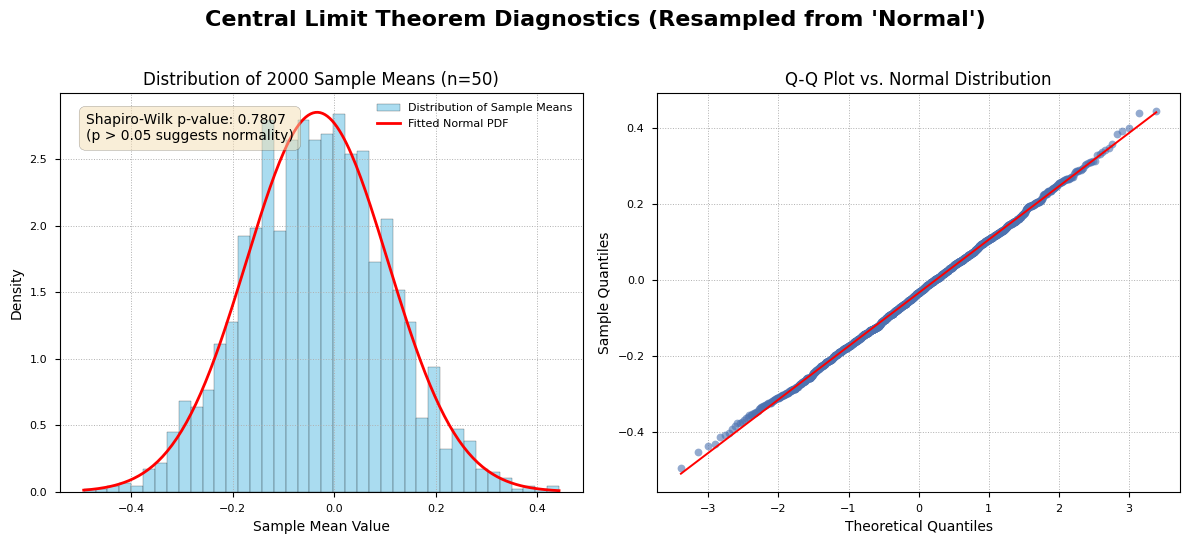

In [ ]:
clt_demo_with_diagnostics(num_samples=2000, resample_size=50)

# Type I and Type II errors in hypothesis testing

Type I error (α):

A false positive. This occurs when a true null hypothesis is incorrectly rejected, leading to the false conclusion that a real effect or difference exists when it does not. The probability of making a Type I error is known as alpha (α) or the significance level.

Type II error (β):

A false negative. This occurs when a false null hypothesis is incorrectly not rejected, meaning a real effect or difference is missed. The probability of making a Type II error is known as beta (β).

Systematic Error: A consistent, predictable error that affects all measurements in the same way, often due to faulty equipment or methodology.


Random Error: An unpredictable, uncontrolled variation in measurements that occurs due to chance.


Measurement Error: Any error that occurs during the process of measuring a variable, encompassing both systematic and random errors.


Sampling Error: An error that occurs because a sample is not perfectly representative of the entire population.

In [ ]:
# --- 2. Part 1: The Visual Power Demo
def visualize_power_tradeoffs(effect_size=0.5, sample_size=30, alpha=0.05):
    """
    Interactively demonstrates the factors affecting statistical power.
    """
    df = (sample_size * 2) - 2
    dist_H0 = stats.t(df=df)
    ncp = effect_size * np.sqrt(sample_size / 2)
    dist_H1 = stats.nct(df=df, nc=ncp)

    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(10, 6), dpi=90)
    x = np.linspace(-5, 5 + effect_size * 2, 500)

    ax.plot(x, dist_H0.pdf(x), color='gray', linestyle='--', label='H₀ Distribution (No Effect)')
    ax.plot(x, dist_H1.pdf(x), color='green', label='H₁ Distribution (True Effect)')

    critical_value = dist_H0.ppf(1 - alpha / 2)
    power = 1 - dist_H1.cdf(critical_value) + dist_H1.cdf(-critical_value)

    x_fill_power = np.linspace(critical_value, x.max(), 100)
    ax.fill_between(x_fill_power, dist_H1.pdf(x_fill_power), color='#32CD32', alpha=0.6, label=f'Power (1-β = {power:.2f})')
    x_fill_power_neg = np.linspace(x.min(), -critical_value, 100)
    ax.fill_between(x_fill_power_neg, dist_H1.pdf(x_fill_power_neg), color='#32CD32', alpha=0.6)

    x_fill_beta = np.linspace(-critical_value, critical_value, 200)
    ax.fill_between(x_fill_beta, dist_H1.pdf(x_fill_beta), color='blue', alpha=0.4, label=f'Type II Error (β = {1-power:.2f})')

    ax.axvline(critical_value, color='black', linestyle=':', lw=1.5, label=f'Critical Value (t={critical_value:.2f})')
    ax.axvline(-critical_value, color='black', linestyle=':', lw=1.5)
    ax.set_title(f'Statistical Power Analysis', fontsize=16, weight='bold')
    ax.set_xlabel('t-Statistic', fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.legend(frameon=False, loc='upper left')
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.ylim(0, 0.45)
    plt.show()

# --- 3. Part 2: The Corrected Practical Calculator ---
def calculate_required_sample_size(effect_size=0.5, power=0.8, alpha=0.05):
    """
    Calculates the required sample size per group for a two-sample t-test
    using the correct library: statsmodels.
    """
    try:
        # The key change is here: using TTestIndPower().solve_power
        analysis = TTestIndPower()
        required_n = analysis.solve_power(
            effect_size=effect_size,
            alpha=alpha,
            power=power,
            ratio=1.0,  # For equal group sizes
            alternative='two-sided'
        )
        # We must have a whole number of participants
        required_n = np.ceil(required_n)
        print(f"To achieve {power*100:.0f}% power with an effect size of {effect_size} and α={alpha},")
        print(f"you need at least {int(required_n)} participants PER GROUP.")
    except Exception as e:
        print(f"Could not calculate sample size. The required N may be too large for these parameters. Error: {e}")

# --- 4. Create and Display the Widgets ---

# Visualizer Widget
power_visualizer = interactive(
    visualize_power_tradeoffs,
    effect_size=FloatSlider(value=0.5, min=0.0, max=2.0, step=0.1, description='Effect Size (d):'),
    sample_size=IntSlider(value=30, min=10, max=200, step=5, description='Sample Size (n):'),
    alpha=FloatSlider(value=0.05, min=0.005, max=0.2, step=0.005, description='Alpha (α):', readout_format='.3f')
)

# Calculator Widget
sample_size_calculator = interactive(
    calculate_required_sample_size,
    effect_size=FloatSlider(value=0.5, min=0.1, max=2.0, step=0.05, description='Effect Size (d):'),
    power=FloatSlider(value=0.8, min=0.5, max=0.99, step=0.01, description='Desired Power:'),
    alpha=FloatSlider(value=0.05, min=0.005, max=0.2, step=0.005, description='Alpha (α):', readout_format='.3f')
)


# Display everything with clear headings
display(Markdown("### Part 1: Visualizing Power Trade-offs"))
display(power_visualizer)
display(Markdown("\n### Part 2: Required Sample Size Calculator"))
display(Markdown("This tool performs a prospective power analysis to help you plan an experiment."))
display(sample_size_calculator)

### Part 1: Visualizing Power Trade-offs

interactive(children=(FloatSlider(value=0.5, description='Effect Size (d):', max=2.0), IntSlider(value=30, des…


### Part 2: Required Sample Size Calculator

This tool performs a prospective power analysis to help you plan an experiment.

interactive(children=(FloatSlider(value=0.5, description='Effect Size (d):', max=2.0, min=0.1, step=0.05), Flo…

# Pearson and Spearman correlation

### Theory: As linear models

**Model:** the recipe for $y$ is a slope ($\beta_1$) times $x$ plus an intercept ($\beta_0$, aka a straight line).

$y = \beta_0 + \beta_1 x \qquad \mathcal{H}_0: \beta_1 = 0$

... which is a math-y way of writing the good old $y = ax + b$ (here ordered as $y = b + ax$). Using `patsy` lets us be a bit lazier and write `y ~ 1 + x` which reads like `y = 1 * number + x * othernumber`, and the task of linear models is simply to find the numbers that best predict `y`.

Either way you write it, it's an intercept ($\beta_0$) and a slope ($\beta_1$) yielding a straight line:

In [ ]:

def linear_regression_plot():
    # Construct data as a pd.DataFrame
    x = np.random.normal(0, 2, 30)
    y = 0.8 * x + 0.2 * 5 * np.random.randn(30)
    df = pd.DataFrame()
    df["x"], df["y"] = x, y

    # Linear regression
    res = smf.ols("y ~ 1 + x", df).fit()
    intercept, slope = res.params

    # Plot
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.scatter(x, y, color="k")
    ax.axhline(intercept, color="b", label=r"$\beta_0$ (Intercept)")
    ax.plot(
        ax.get_xlim(),
        [slope * x + intercept for x in ax.get_xlim()],
        color="r",
        label=r"$\beta_1$ (Slope)",
    )
    ax.legend()

    return fig, ax


# pylint: disable=R0914
def pearson_spearman_plot():
    # Construct data as pd.DataFrames
    x = np.random.normal(0, 2, 30)
    y = 0.8 * x + 0.2 * 5 * np.random.randn(30)
    data_pearson = pd.DataFrame()
    data_pearson["x"], data_pearson["y"] = x, y
    data_spearman = data_pearson.rank()

    # Pearson equivalent linear model
    res_pearson = smf.ols("y ~ 1 + x", data_pearson).fit()
    intercept_pearson, slope_pearson = res_pearson.params

    # Spearman equivalent linear model
    res_spearman = smf.ols("y ~ 1 + x", data_spearman).fit()
    intercept_spearman, slope_spearman = res_spearman.params

    # Plot
    fig, axarr = plt.subplots(ncols=2, figsize=[18, 8])

    for ax, dataset, to_str, title, a, b in zip(
        axarr,
        [data_pearson, data_spearman],
        [format_decimals_factory(), format_decimals_factory(0)],
        ["Pearson", "Spearman"],
        [slope_pearson, slope_spearman],
        [intercept_pearson, intercept_spearman],
    ):
        ax.scatter(dataset["x"], dataset["y"], color="k")

        annotations = (
            "(" + dataset["x"].apply(to_str) + ", " + dataset["y"].apply(to_str) + ")"
        )
        for i, annot in enumerate(annotations):
            ax.annotate(annot, (dataset["x"][i], dataset["y"][i]), color="grey")

        ax.axhline(a, color="b", label=r"$\beta_0$ (Intercept)")
        ax.plot(
            ax.get_xlim(),
            [a * x + b for x in ax.get_xlim()],
            color="r",
            label=r"$\beta_1$ (Slope)",
        )

        ax.set_title(title)
        ax.legend(fontsize="large")

    return fig, axarr


def format_decimals_factory(num_decimals=1):
    return lambda x: "{1:.{0}f}".format(num_decimals, x)

def pairs_wilcoxon_plot():
    # Construct data as a pd.DataFrame
    y = np.random.normal(2, 1, 20)
    y2 = y + np.random.randn(20)
    df = pd.DataFrame()
    df["y"], df["y2"], df["y_sub_y2"] = y, y2, y - y2

    # Wilcoxon equivalent linear model
    res = smf.ols(formula="y_sub_y2 ~ 1", data=df).fit()
    intercept_wilcoxon = res.params.Intercept

    # Plot
    fig, axarr = plt.subplots(ncols=2, figsize=[18, 8])

    # Left hand figure
    axarr[0].scatter(np.zeros_like(df.y), df.y.values, color="k")
    axarr[0].scatter(np.ones_like(df.y2), df.y2.values, color="k")

    for i, j in zip(df.y, df.y2):
        axarr[0].plot([0, 1], [i, j], color="k")

    axarr[0].set_title("Pairs")

    # Right hand figure
    axarr[1].scatter(np.zeros_like(df.y_sub_y2), df.y_sub_y2.values, color="k")

    annotations = df.y_sub_y2.apply(format_decimals_factory())
    for i, annot in enumerate(annotations):
        axarr[1].annotate(annot, (0, df.y_sub_y2[i]), color="grey")

    axarr[1].axhline(intercept_wilcoxon, color="b", label=r"$\beta_0$ (Intercept)")

    axarr[1].set_title("$t$-test")
    axarr[1].legend(fontsize="large")

    return fig, axarr



def tabulate_results(test_values, ols_results, names, coeff="x"):
    """
    Tabulates results of statistical tests and equivalent linear regressions to
    demonstrate that the two methods are in fact equivalent.

    Parameters
    ----------
    test_values : list
        List of values from the scipy statistical test to display.
    ols_results : statsmodels.RegressionResults or list thereof
        Result object(s) of equivalent linear regression to display.
    names : list
        List of strings to display.
    coeff : str
        Name of coefficient whose test statistics should be displayed. Defaults
        to "x".

    Returns
    -------
    table : pd.DataFrame
    """
    # There may be only one OLS result. If so, wrap it up as a single list.
    if not isinstance(ols_results, list):
        ols_results = [ols_results]

    # Assert shapes
    assert len(test_values) == 5
    assert len(names) == len(ols_results) + 1

    # Construct and return table
    table = pd.DataFrame(index=names)
    table["value"] = [test_values[0]] + [res.params[coeff] for res in ols_results]
    table["p-values"] = [test_values[1]] + [res.pvalues[coeff] for res in ols_results]
    table["t-values"] = [test_values[2]] + [res.tvalues[coeff] for res in ols_results]
    table["0.025 CI"] = [test_values[3]] + [
        res.conf_int().loc[coeff, 0] for res in ols_results
    ]
    table["0.975 CI"] = [test_values[4]] + [
        res.conf_int().loc[coeff, 1] for res in ols_results
    ]

    return table

def signed_rank(df):
    return np.sign(df) * df.abs().rank()



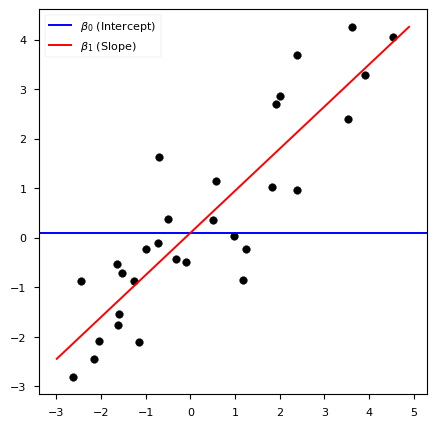

In [ ]:
linear_regression_plot()
plt.show()

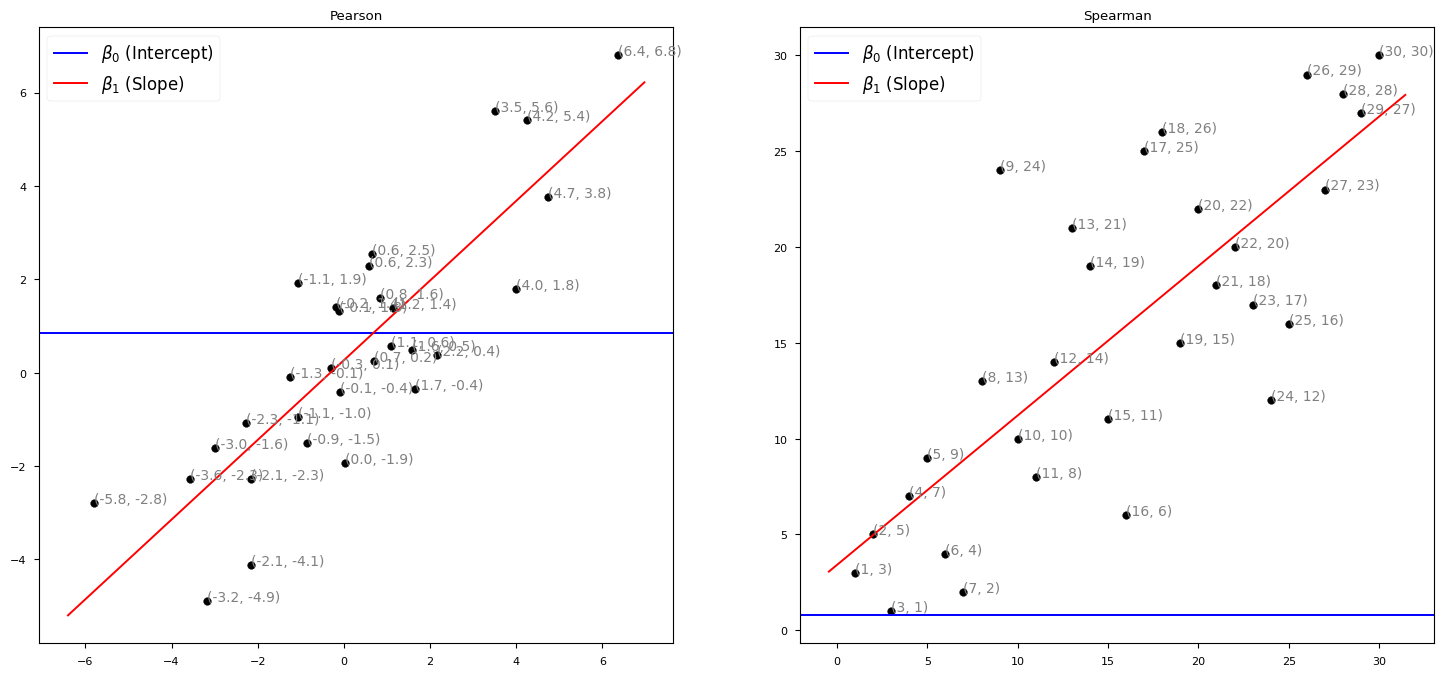

In [ ]:
pearson_spearman_plot()
plt.show()

It couldn't be much simpler to run these models with `statsmodels` ([`smf.ols`](https://www.statsmodels.org/stable/example_formulas.html#ols-regression-using-formulas)) or `scipy` ([`scipy.stats.pearson`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)). They yield identical slopes, `p` and `t` values, but there's a catch: `smf.ols` gives you the *slope* and even though that is usually much more interpretable and informative than the _correlation coefficient_ $r$, you may still want $r$. Luckily, the slope becomes $r$ if `x` and `y` have a standard deviation of exactly 1. You can do this by scaling the data: `data /= data.std()`.

Notice how `scipy.stats.pearsonr` and `smf.ols (scaled)` have the same slopes, $p$ and $t$ values. Also note that statistical functions from `scipy.stats` do not provide confidence intervals, while performing the linear regression with `smf.ols` does.

In [ ]:
correlated = pd.DataFrame()
correlated["x"] = np.linspace(0, 1)
correlated["y"] = 1.5 * correlated.x + 2 * np.random.randn(len(correlated.x))

scaled = correlated / correlated.std()

r, p = scipy.stats.pearsonr(correlated["x"], correlated["y"])
res1 = smf.ols(formula="y ~ 1 + x", data=correlated).fit()
res2 = smf.ols(formula="y ~ 1 + x", data=scaled).fit()

In [ ]:
tabulate_results([r, p, None, None, None],
                       [res1, res2],
                       ["scipy.stats.pearsonr", "smf.ols", "smf.ols (scaled)"])

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.pearsonr,0.333810,0.017832,NaN,NaN,NaN
smf.ols,2.783249,0.017832,2.453429,0.502320,5.064177
smf.ols (scaled),0.333810,0.017832,2.453429,0.060246,0.607374


### Example data

In [ ]:
data = pd.DataFrame()
data["x"] = np.random.normal(loc=0.0, scale=1.0, size=50)  # Used in correlation where this is on x-axis
data["y"] = np.random.normal(loc=0.5, scale=1.0, size=50)  # Almost zero mean
data["y2"] = np.random.normal(loc=0.8, scale=1.0, size=50)  # Used in two means
data["y_sub_y2"] = data["y"] - data["y2"]

data.head()

,x,y,y2,y_sub_y2
0,-0.586629,2.995265,0.926954,2.068310
1,-1.121456,0.256450,0.712537,-0.456086
2,0.266437,-0.043508,1.431253,-1.474762
3,-0.857596,0.652225,-0.022864,0.675089
4,-1.650096,0.293789,1.390992,-1.097203


In [ ]:
signed_rank_data = signed_rank(data)

_, p = scipy.stats.wilcoxon(data.y)
res = smf.ols("y ~ 1", data=signed_rank_data).fit()

In [ ]:
tabulate_results([None, p, None, None, None],
                       res,
                       ["scipy.stats.wilcoxon", "smf.ols (y ~ 1, signed rank)"],
                       coeff="Intercept")

,value,p-values,t-values,0.025 CI,0.975 CI
scipy.stats.wilcoxon,NaN,0.001978,NaN,NaN,NaN
"smf.ols (y ~ 1, signed rank)",12.58,0.001667,3.327776,4.983198,20.176802


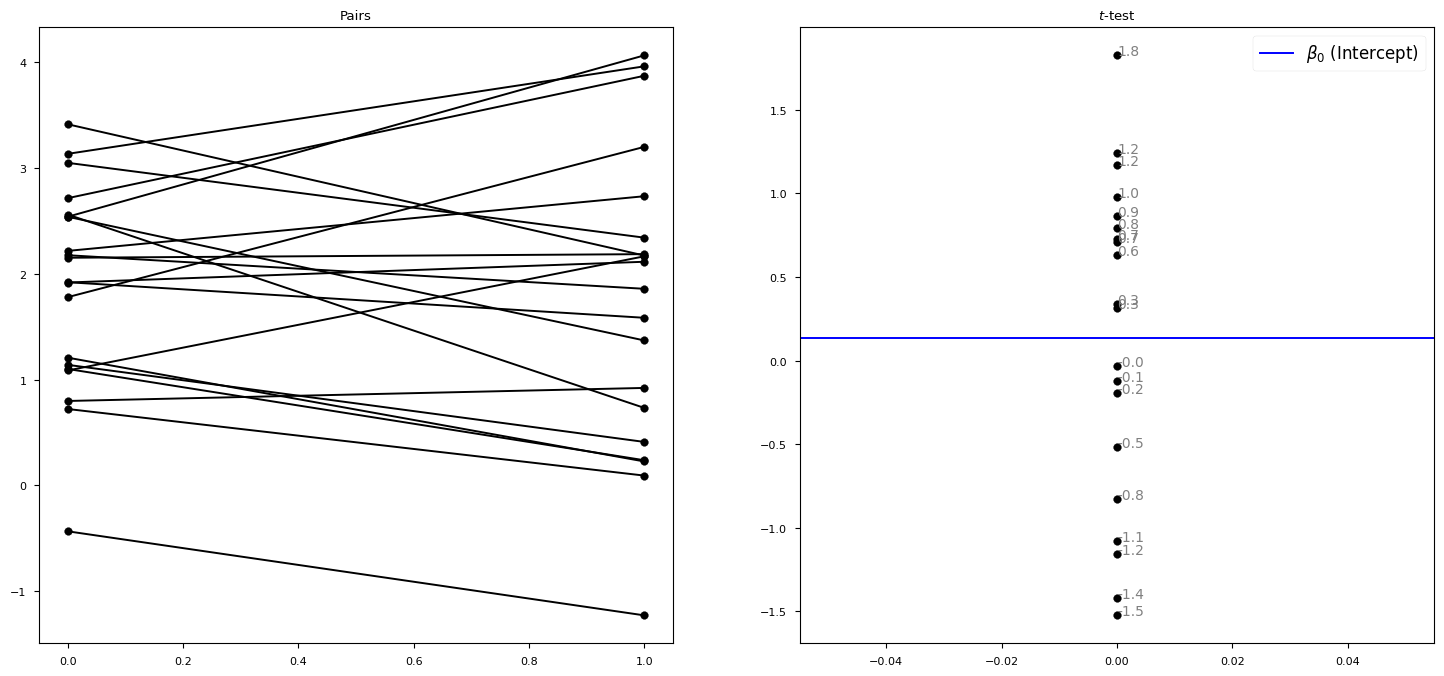

In [ ]:
pairs_wilcoxon_plot()
plt.show()